# Определение перспективного тарифа для телеком-компании

# Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: `Smart` и `Ultra`. Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов

**Тариф `Smart`**

+ Ежемесячная плата: 550 рублей
+ Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
+ Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

**Тариф `Ultra`**

+ Ежемесячная плата: 1950 рублей
+ Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
+ Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv', index_col=0)
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv', index_col=0)
tariffs = pd.read_csv('/datasets/tariffs.csv', index_col=0)
users = pd.read_csv('/datasets/users.csv', index_col=0)

In [3]:
for data in [calls, internet, messages, users, tariffs]: print(data.info(), end='\n\n\n')

<class 'pandas.core.frame.DataFrame'>
Index: 202607 entries, 1000_0 to 1499_219
Data columns (total 3 columns):
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.2+ MB
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB
None


<class 'pandas.core.frame.DataFrame'>
Index: 123036 entries, 1000_0 to 1499_183
Data columns (total 2 columns):
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.8+ MB
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1000 to 1499
Data columns (total 7 columns):
age           500 non-

**Вывод**

Датасет содержит данные по 500 клиентам, потребуется заменить тип данных у столбцов с датой и временем, а также округлить значения минут разговора и мегабайт использованного трафика в большую сторону, так как тарифы считаются по минутам и мегабайтам.

Кроме того, после объединения данных (сводная таблица по звонкам, по сообщениям и интернет-трафику) возникнут пропущенные значения (клиент мог в каком-то месяце не писать сообщений, но звонить и использовать интернет), которые также нужно будет заменить на нули.

## Предобработка данных

**Изменим тип данных:**

In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

**Исправим ошибки в данных:**

**Звонки**

In [5]:
print('Количество звонков с длительностью, равной нулю:',
      calls.loc[calls['duration'] == 0, 'duration'].
      value_counts()[0])

Количество звонков с длительностью, равной нулю: 39613


In [6]:
# добавим столбец со значением месяца
calls['month'] = calls['call_date'].dt.month

# округлим время звонков  в большую сторону
calls['duration'] = calls['duration'].apply(np.ceil)

**Интернет**

In [7]:
# добавим столбец со значением месяца
internet['month'] = internet['session_date'].dt.month

# округлим веб-трафик в большую сторону
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

**Сообщения**

In [8]:
# добавим столбец со значением месяца
messages['month'] = messages['message_date'].dt.month

**Расчет значений для каждого пользователя:**

+ количество сделанных звонков и израсходованных минут разговора по месяцам;
+ количество отправленных сообщений по месяцам;
+ объем израсходованного интернет-трафика по месяцам;

In [9]:
# для подсчета при создании сводной таблицы добавим столбец с уникальным id клиентов
users['unique_name'] = users.index

In [10]:
# сводная таблица по звонкам
calls_merge = calls.merge(users, on='user_id', how='inner')
calls_grouped = calls_merge.pivot_table(values=['unique_name', 'duration'], 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count', 'duration': 'sum'})
calls_grouped.columns = ['duration', 'calls']

In [11]:
# сводная таблица по интернет-трафику
internet_merge = internet.merge(users, on='user_id', how='inner')
internet_grouped = internet_merge.pivot_table(values='mb_used', 
                       index=['user_id', 'month'], 
                       aggfunc={'mb_used': 'sum'})
internet_grouped.columns = ['mb_used']

In [12]:
# сводная таблица по сообщениям
messages_merge = messages.merge(users, on='user_id', how='inner')
messages_grouped = messages_merge.pivot_table(values='unique_name', 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count'})
messages_grouped.columns = ['messages']

In [13]:
# объединяем все три сводные таблицы в одну
grouped_data = calls_grouped.merge(messages_grouped, on=['user_id', 'month'], how='outer')
grouped_data = grouped_data.merge(internet_grouped, on=['user_id', 'month'], how='outer')
grouped_data.head(10)

duration  calls  messages  mb_used
user_id month                                    
1000    5         159.0   22.0      22.0   2256.0
        6         172.0   43.0      60.0  23257.0
        7         340.0   47.0      75.0  14016.0
        8         408.0   52.0      81.0  14070.0
        9         466.0   58.0      57.0  14581.0
        10        350.0   57.0      73.0  14717.0
        11        338.0   43.0      58.0  14768.0
        12        333.0   46.0      70.0   9827.0
1001    11        430.0   59.0       NaN  18452.0
        12        414.0   63.0       NaN  14053.0

**Теперь посчитаем:**

+ помесячную выручку с каждого пользователя (  
вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;  
остаток умножим на значение из тарифного плана;  
прибавим абонентскую плату, соответствующую тарифному плану).

In [14]:
# пропущенные значения заменим на нули
grouped_data.loc[grouped_data['duration'].isna(), 'duration'] = 0
grouped_data.loc[grouped_data['messages'].isna(), 'messages'] = 0
grouped_data.loc[grouped_data['mb_used'].isna(), 'mb_used'] = 0

In [15]:
# добавим наименование используемого тарифа для каждого пользователя
for user in users.unique_name:
    grouped_data.loc[user, 'tariff'] = users.loc[user, 'tariff']
grouped_data.dropna(inplace=True)

In [16]:
grouped_data.head(10)

duration  calls  messages  mb_used tariff
user_id month                                           
1000    5         159.0   22.0      22.0   2256.0  ultra
        6         172.0   43.0      60.0  23257.0  ultra
        7         340.0   47.0      75.0  14016.0  ultra
        8         408.0   52.0      81.0  14070.0  ultra
        9         466.0   58.0      57.0  14581.0  ultra
        10        350.0   57.0      73.0  14717.0  ultra
        11        338.0   43.0      58.0  14768.0  ultra
        12        333.0   46.0      70.0   9827.0  ultra
1001    11        430.0   59.0       0.0  18452.0  smart
        12        414.0   63.0       0.0  14053.0  smart

In [17]:
tariffs

,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
messages_included,,,,,,,
50,15360,500,550,200,3,3,smart
1000,30720,3000,1950,150,1,1,ultra


In [18]:
# функция подсчета выручки с каждого пользователя в месяц
def get_revenue(row):
    messages = row['messages']
    mb_used = row['mb_used']
    tariff = row['tariff']
    duration = row['duration']
    calls = row['calls']
    
    if tariff == 'smart':
        extra_duration = duration - tariffs.iloc[0, 1]
        extra_mb = mb_used - tariffs.iloc[0, 0]
        extra_messages = messages - tariffs.index[0]
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.iloc[0, 4] * extra_messages + 
                   (tariffs.iloc[0, 3] / 1024) * extra_mb + 
                   tariffs.iloc[0, 5] * extra_duration + 
                   tariffs.iloc[0, 2]
                  ) 
    else:
        extra_duration = duration - tariffs.iloc[1, 1]
        extra_mb = mb_used - tariffs.iloc[1, 0]
        extra_messages = messages - tariffs.index[1]
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.iloc[1, 4] * extra_messages + 
                   (tariffs.iloc[1, 3] / 1024) * extra_mb + 
                   tariffs.iloc[1, 5] * extra_duration + 
                   tariffs.iloc[1, 2]
                  )

grouped_data['revenue'] = grouped_data.apply(get_revenue, axis=1)
grouped_data.head(10)

duration  calls  messages  mb_used tariff     revenue
user_id month                                                       
1000    5         159.0   22.0      22.0   2256.0  ultra  1950.00000
        6         172.0   43.0      60.0  23257.0  ultra  1950.00000
        7         340.0   47.0      75.0  14016.0  ultra  1950.00000
        8         408.0   52.0      81.0  14070.0  ultra  1950.00000
        9         466.0   58.0      57.0  14581.0  ultra  1950.00000
        10        350.0   57.0      73.0  14717.0  ultra  1950.00000
        11        338.0   43.0      58.0  14768.0  ultra  1950.00000
        12        333.0   46.0      70.0   9827.0  ultra  1950.00000
1001    11        430.0   59.0       0.0  18452.0  smart  1153.90625
        12        414.0   63.0       0.0  14053.0  smart   550.00000

## Анализ данных

**Посчитаем:**

+ сколько в среднем каждому пользователю требуется минут, сообщений и мегабайт в месяц

In [19]:
medians = grouped_data.pivot_table(index='user_id',
                                   values=['duration', 'messages', 'mb_used', 'revenue'],
                                   aggfunc='median')
for user in users.unique_name:
    medians.loc[user, 'tariff'] = users.loc[user, 'tariff']
medians.head()

,duration,mb_used,messages,revenue,tariff
user_id,,,,,
1000,339.0,14325.5,65.0,1950.000000,ultra
1001,422.0,16252.5,0.0,851.953125,smart
1002,214.0,17601.0,11.0,987.695312,smart
1003,824.0,11368.0,83.0,1950.000000,ultra
1004,132.5,17828.5,154.5,1950.000000,ultra


**Найдем:**

+ медиану
+ дисперсию
+ стандартное отклонение

In [20]:
medians.dropna(subset=['duration'], inplace=True)
users_stat = medians.pivot_table(index=['tariff'], values=['duration', 'messages', 'mb_used'], 
                    aggfunc={'duration': [np.median, np.var, np.std], 
                             'messages': [np.median, np.var, np.std], 
                             'mb_used': [np.median, np.var, np.std]})
users_stat

duration                            mb_used                             \
         median         std           var   median          std           var   
tariff                                                                          
smart     440.0  158.761565  25205.234463  16935.0  4185.707737  1.752015e+07   
ultra     546.0  290.153182  84188.868930  19826.0  8903.219170  7.926731e+07   

       messages                          
         median        std          var  
tariff                                   
smart      28.5  28.042491   786.381307  
ultra      49.5  48.496913  2351.950532

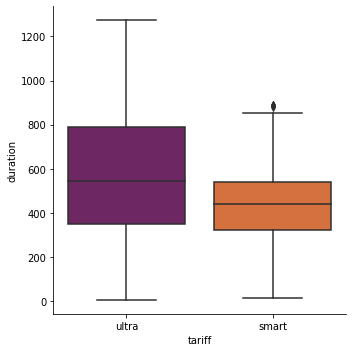

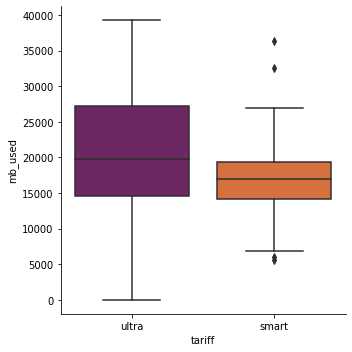

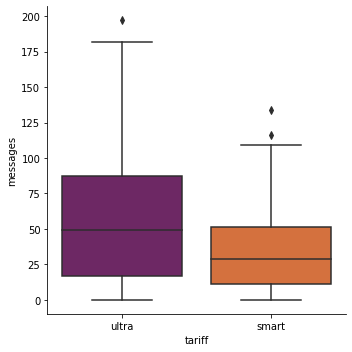

In [21]:
for column in ['duration', 'mb_used', 'messages']:    
    sns.catplot(x="tariff", y=column, kind="box", data=medians, palette='inferno')

**Вывод:**

Минуты разговора, объём веб-трафика и число сообщений по тарифу `Ultra` имеют большую дисперсию по сравнению с тарифом `Smart`, и медианы по этим признакам также смещены в большую сторону. Кроме того, выбросов в рамках более дешевого тарифа существенно больше.

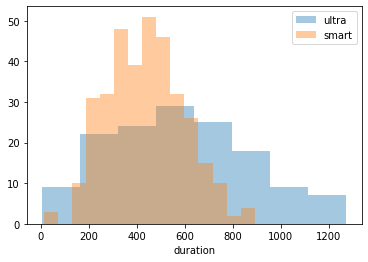

In [22]:
for tariff in ['ultra', 'smart']:
    sns.distplot(medians.query('tariff == @tariff')['duration'], kde=False)
    plt.legend(['ultra', 'smart'])

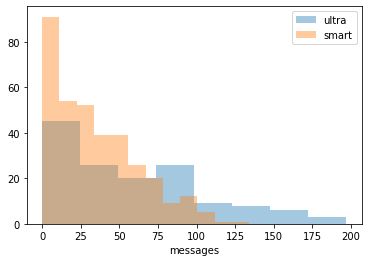

In [23]:
for tariff in ['ultra', 'smart']:
    sns.distplot(medians.query('tariff == @tariff')['messages'], kde=False)
    plt.legend(['ultra', 'smart'])

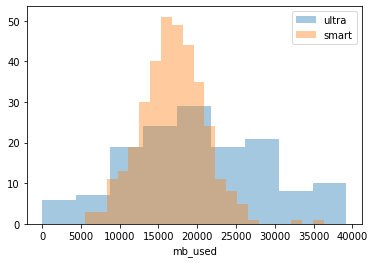

In [24]:
for tariff in ['ultra', 'smart']:
    sns.distplot(medians.query('tariff == @tariff')['mb_used'], kde=False)
    plt.legend(['ultra', 'smart'])

**Вывод:**

На гистограммах наглядно видно, что дисперсия по тарифу `Smart` меньше, чем у пользователей с тарифом `Ultra` по всем показателям:
+ по длительности разговора
+ числу сообщений
+ использованному интернет-трафику

Также на гистограммах видно, что мода у тарифа `Smart` явно выражена.

Можно предположить, что пользователи тарифа `Ultra` более свободны в выборе того, как им использовать объемы тарифного пакета. Они могут не думать о том, что в какой-то момент у них отключится интернет или закончится лимит по минутам разговора.

## Проверка гипотез

**Проверим две гипотезы:**

+ средняя выручка пользователей тарифов `Ultra` и `Smart` различаются;
+ средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.

**Первая гипотеза:**

***H0***  — средняя выручка пользователей тарифа `Ultra` равна средней выручке пользователей тарифа `Smart`.

***H1*** — средняя выручка пользователей тарифов `Ultra` и `Smart` различаются.

***α*** = 1%

In [25]:
ultra = grouped_data.query('tariff == "ultra"')['revenue']
smart = grouped_data.query('tariff == "smart"')['revenue']

alpha = .01

results = st.ttest_ind(ultra, smart, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.525672521930252e-290
Отвергаем нулевую гипотезу


In [26]:
grouped_data.pivot_table(index='tariff', values='revenue', aggfunc='median')

,revenue
tariff,
smart,961.09375
ultra,1950.00000


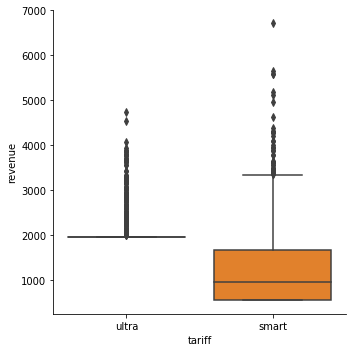

In [27]:
sns.catplot(x="tariff", y='revenue', kind="box", data=grouped_data)
plt.show()

**Вывод:**

Средние значения выручки по тарифам различаются почти в 2 раза. Если у пользователя подключен тариф `Smart` с абонентской платой в 550 рублей, то он скорее всего по итогам месяца заплатит гораздо больше из-за нехватки услуг в рамках тарифного пакета.

В заключение можно с уверенностью 99% подтвердить, что доходы "Мегалайна" с пользователя по тарифу `Ultra` действительно отличаются от доходов по тарифу `Smart`.

**Вторая гипотеза:**

***H0*** — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

***H1***  — средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.

***α*** = 1%

In [28]:
# добавим наименование города для каждого пользователя
for user in users.unique_name:
    grouped_data.loc[user, 'city'] = users.loc[user, 'city']
grouped_data.dropna(inplace=True)

In [29]:
moscow = grouped_data.query('city == "Москва"')['revenue']
regions = grouped_data.query('city != "Москва"')['revenue']

alpha = .01

results = st.ttest_ind(
    moscow, 
    regions, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.3720425188871448
Не получилось отвергнуть нулевую гипотезу


In [30]:
def det_region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'
    
grouped_data['region'] = grouped_data['city'].apply(det_region)
grouped_data.pivot_table(index='region', values='revenue', aggfunc='median')

,revenue
region,
Другой регион,1494.101562
Москва,1689.816406


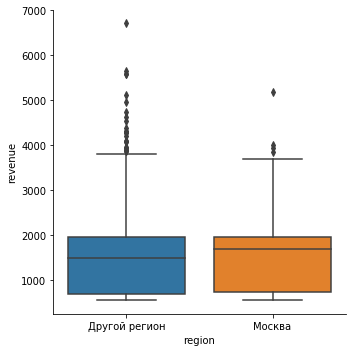

In [31]:
sns.catplot(x="region", y='revenue', kind="box", data=grouped_data)
plt.show()

**Вывод:**

Проведенный статистический тест не дал возможности опровергунть исходную гипотезу о том, что доходы от пользователей из Москвы и из других регионов равны. В действительности, доходы в Московском регионе практически не отличаются от других населенных пунктов.

Если бы мы отклонили нулевую гипотезу и подтвердили, что доходы "Мегалайна" с каждого пользователя в Москве отличаются от доходов в других регионах, мы бы с вероятностью 37,2% ошиблись.

## Общий вывод

По результатам статистического анализа доходы от тарифа `Ultra` почти в 2 раза больше, чем от тарифа `Smart`: в среднем «Мегалайн» от одного пользователя в месяц получает 1950 рублей и 961 рубль соответственно.

Особенности использования тарифов заключаются в следующем:

+ Пользователям тарифа `Smart` не хватает услуг в рамках тарифного пакета: кроме абонентской платы пользователи в среднем доплачивают еще 411 рублей ежемесячно (+74,7%).
+ Пользователи тарифа `Ultra`, напротив, не используют тарифный пакет в полном объеме.
+ Средние доходы от пользователей в Москве не отличаются от доходов в других населенных пунктах: разница статистически незначима (p-значение: 0,372) и составляет 195 руб. (1689 руб. в Москве против 1494 руб в других городах).